In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import warnings
from func import ind, fl, fitData
warnings.filterwarnings("ignore")

Inserting Prepared Data

In [2]:
data = pd.read_csv('/home/ict4bd/Desktop/Project/Data_Output/Data_for_ARIMA.csv',sep=',',decimal=',', low_memory=False)

Define a list with just value and Converting Data from STRING to FLOAT


In [3]:
data = fl(data)
X = data.total_power.values.astype(float)

Defining Training and test size for ARIMA Model

In [4]:
# amount of data in the initial window of training
training_size = 24*365*2
# number of tests to be done for which we repeat the train and test
test_size = 24*30

Ordering P (autocorrelation value) and Q (partial autocorrelation)

In [5]:
p_order = (1,3,7,9)
q_order = (1,2,3,7,8)
# fixed parameters [needed for non-stationarity of the series -> parabolic trend] but in our case is 0
d = 0

Main part of Process (grid search)

In [ ]:
best_mse, best_order = float("inf"), None
result_temp = []

for q in q_order:
    for p in p_order:
        print('Testing p =', p, 'and q =', q)
        order = (p, d, q)
        # split train and test
        train = X[0:training_size]
        test = X[training_size:training_size + test_size]

        predictions = list()
        # data for training
        history = [x for x in train]
        # for all tests
        for t in range(0, test_size):
            # new ARIMA model
            try:
                model = ARIMA(history, order=order)
                # fit it
                model_fit = model.fit(method='css', disp=0)
                # forecasted data at t+j
                output = model_fit.forecast()[0][0]
                print(output)
                # get t+1 -> sorting obs
                predictions.append(output)
                # slide over time by putting now+1 into past
                history.append(test[t])
                # drop first sample to use sliding window (to use expanding window, comment the following line)
                histroy = history[1:]
            except:
                print("* ERROR IN TRAINING THE MODEL *")

        mse = mean_squared_error(test, predictions)
        mape = np.mean(np.abs((test - predictions) / test)) * 100
        result_temp.append({'p': p, 'q': q, 'mse': mape})
        print (result_temp)
        if mse < best_mse:
            best_mse, best_order = mse, order
print('Best ARIMA%s MSE=%.3f' % (best_order, best_mse))
# for residuals plot
plt.figure()
result = pd.DataFrame.from_dict(result_temp)
result.to_csv('/home/ict4bd/Desktop/Project/Data_Output/Grid_Search_Result.csv', index=False)

Because the last piece of code is really heavy in order to process and time, we split it into smaller part
and the result obtained in unic file of CSV as Follow

In [6]:
grid_search_result = pd.read_csv('/home/ict4bd/Desktop/Project/Data_Output/Grid_Search_Result.csv',sep=',',decimal=',', low_memory=False)

In [7]:
grid_search_result['mse'] = pd.to_numeric(grid_search_result['mse'], errors='coerce')
grid_search_result['mse'] = grid_search_result['mse'].apply(lambda x: round(x, 4))

In [8]:
ax = grid_search_result.pivot(index='q', columns='p', values='mse')
ax

p,1,3,7,9
q,,,,
1,1.0891,1.0758,1.0364,1.1635
2,1.0731,1.0745,1.0528,1.1327
3,1.0739,1.0743,1.0293,1.1003
7,1.1289,1.0662,0.9155,0.9709
8,1.0603,1.0740,1.0112,0.9426


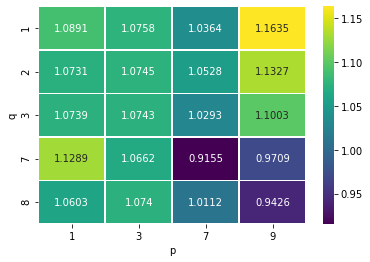

In [9]:
show = sns.heatmap(ax, annot=True, fmt='g', cmap='viridis',  linewidth=0.5)
plt.show()